In [19]:
import pandas as pd
import numpy as np

# Cargar datos
usuarios = pd.read_csv("usuarios.csv", sep=";")
usuarios.rename(columns={"login": "Login"}, inplace=True)
usuarios = usuarios[["Login", "metaretailer (Retailer)", "metaemployeetype (Employee Type)", "metashopcode (Door Code)", "metashopname (Door Name)","metalocation (Location)"]]


cursos = pd.read_excel("cursos.xlsx", header=5)
cursos = cursos[["Login","# of completed T.C","# of started T.C","# of succeeded T.C", "# of available T.C - All Time"]]

## Usuarios

In [20]:

# Filtrar usuarios de fuerza externa
usuarios_type8 = usuarios[usuarios['metaemployeetype (Employee Type)'] == 8]
usuarios_type8 = usuarios_type8[usuarios_type8['metaretailer (Retailer)'].isin(["PREUNIC", "MAICAO"])]

# Unir con la tabla de cursos
usuarios_cursos = pd.merge(usuarios_type8, cursos, on="Login", how="left")

# Total de perfiles creados
total_perfiles = len(usuarios_type8)

# % de la fuerza de ventas con perfil creado (de 2000)
porcentaje_perfiles = (total_perfiles / 2000) * 100

# Usuarios con ≥ 3 cursos completados
usuarios_con_3 = usuarios_cursos[usuarios_cursos['# of completed T.C'] >= 3]

usuarios_con = usuarios_cursos[usuarios_cursos['# of completed T.C'] >= 0]

# % de estos usuarios sobre perfiles creados y sobre total fuerza de venta
porcentaje_3_sobre_perfiles = (len(usuarios_con_3) / total_perfiles) * 100
porcentaje_3_sobre_total = (len(usuarios_con_3) / 2000) * 100

# Total de cursos completados
total_cursos_8 = usuarios_cursos['# of completed T.C'].sum()

# Equivalente en capacitaciones (/3)
total_capacitaciones = total_cursos_8 / 3

# Capacitaciones promedio por perfil creado y por total
cap_por_perfil = total_capacitaciones / total_perfiles
cap_por_total = total_capacitaciones / 2000
cap_por_total_full = total_capacitaciones / 8345


#Tasa de finalización
total_succeeded = usuarios_cursos['# of succeeded T.C'].sum()
total_completed = usuarios_cursos['# of completed T.C'].sum()
porcentaje_success = (total_succeeded / total_completed) * 100 if total_completed > 0 else 0
tasa_finalizacion = (usuarios_cursos['# of completed T.C'].sum() / usuarios_cursos['# of started T.C'].sum()) * 100




# Mostrar resultados
print(f"Perfiles creados: {total_perfiles:.2f}")
print(f"% perfiles creados: {porcentaje_perfiles:.2f}%")
print(f"Usuarios con ≥0 cursos completados: {len(usuarios_con)}")
print(f"% con ≥0 cursos (sobre perfiles creados): {(len(usuarios_con) / total_perfiles) * 100:.2f}%")
print(f"% con ≥0 cursos (sobre total): {(len(usuarios_con) / 2000) * 100:.2f}%")
print(f"Usuarios con ≥3 cursos completados: {len(usuarios_con_3)}")
print(f"% con ≥3 cursos (sobre perfiles creados): {porcentaje_3_sobre_perfiles:.2f}%")
print(f"% con ≥3 cursos (sobre total): {porcentaje_3_sobre_total:.2f}%")



Perfiles creados: 356.00
% perfiles creados: 17.80%
Usuarios con ≥0 cursos completados: 105
% con ≥0 cursos (sobre perfiles creados): 29.49%
% con ≥0 cursos (sobre total): 5.25%
Usuarios con ≥3 cursos completados: 51
% con ≥3 cursos (sobre perfiles creados): 14.33%
% con ≥3 cursos (sobre total): 2.55%


In [21]:
print(f"Total cursos completados: {total_cursos_8}")
print(f"Total capacitaciones (÷3): {total_capacitaciones:.2f}")
print(f"Capacitaciones por perfil creado: {cap_por_perfil:.2f}")
print(f"Capacitaciones por total (2000): {cap_por_total:.2f}")
print(f"Capacitaciones por total (8345): {cap_por_total_full:.2f}")
print(f"Porcentaje de cursos exitosos: {porcentaje_success:.2f}%")
print(f"Tasa de finalización: {tasa_finalizacion:.2f}%")

Total cursos completados: 723.0
Total capacitaciones (÷3): 241.00
Capacitaciones por perfil creado: 0.68
Capacitaciones por total (2000): 0.12
Capacitaciones por total (8345): 0.03
Porcentaje de cursos exitosos: 93.08%
Tasa de finalización: 91.75%


In [22]:
# Usuarios con al menos un curso comenzado pero ninguno completado
usuarios_incompletos = usuarios_cursos[
    (usuarios_cursos['# of started T.C'] >= 1) &
    ((usuarios_cursos['# of completed T.C'].isna()) | (usuarios_cursos['# of completed T.C'] == 0))
]
porcentaje_incompletos = (len(usuarios_incompletos) / total_perfiles) * 100

print(f"Usuarios con cursos comenzados pero ninguno completado: {len(usuarios_incompletos)}")
print(f"% con cursos comenzados pero ninguno completado (sobre perfiles creados): {porcentaje_incompletos:.2f}%")

Usuarios con cursos comenzados pero ninguno completado: 21
% con cursos comenzados pero ninguno completado (sobre perfiles creados): 5.90%


In [23]:
# Capacitaciones por perfil (dividir cursos completados por 3)
usuarios_cursos['capacitaciones_por_usuario'] = usuarios_cursos['# of completed T.C'] / 3
cap_por_usuario = usuarios_cursos.groupby('Login')['capacitaciones_por_usuario'].sum()

# Desviación estándar de capacitaciones por perfil
desviacion_std_cap = cap_por_usuario.std()
mediana_cap = cap_por_usuario.median()

print(f"Desviación estándar de capacitaciones por perfil: {desviacion_std_cap:.2f}")
print(f"Mediana de capacitaciones por perfil: {mediana_cap:.2f}")



Desviación estándar de capacitaciones por perfil: 1.90
Mediana de capacitaciones por perfil: 0.00


## Locales

In [24]:

cursos_por_local = usuarios_cursos.groupby('metashopcode (Door Code)').agg(
    total_cursos=('# of completed T.C', 'sum')  # ajusta si hay espacios
).reset_index()

# Limpiar códigos de local
usuarios_type8['metashopcode (Door Code)'] = usuarios_type8['metashopcode (Door Code)'].replace("-", np.nan)

# Total de locales posibles
total_locales = 302

# 1. Locales alcanzados (con al menos un perfil creado)
locales_alcanzados = usuarios_type8['metashopcode (Door Code)'].nunique()
locales_PU = usuarios_type8[usuarios_type8['metaretailer (Retailer)'] == "PREUNIC"]['metashopcode (Door Code)'].nunique()
locales_MC = usuarios_type8[usuarios_type8['metaretailer (Retailer)'] == "MAICAO"]['metashopcode (Door Code)'].nunique()
porcentaje_alcanzados = (locales_alcanzados / total_locales) * 100

# 2. Locales con ≥3 cursos acumulados (de cursos_por_local)
locales_con_capacitacion = cursos_por_local[cursos_por_local['total_cursos'] >= 3]['metashopcode (Door Code)'].dropna().unique()
cantidad_locales_con_cap = len(locales_con_capacitacion)
porcentaje_locales_capacitados = (cantidad_locales_con_cap / total_locales) * 100


# ---------------- Mostrar ----------------
print(f"Locales alcanzados (con perfiles creados): {locales_alcanzados} de {total_locales} ({porcentaje_alcanzados:.2f}%)")
print(f"Locales PREUNIC alcanzados: {locales_PU}")
print(f"Locales MAICAO alcanzados: {locales_MC}")

print(f"Locales con ≥3 cursos acumulados (entre todos sus usuarios): {cantidad_locales_con_cap} ({porcentaje_locales_capacitados:.2f}%)")


Locales alcanzados (con perfiles creados): 105 de 302 (34.77%)
Locales PREUNIC alcanzados: 44
Locales MAICAO alcanzados: 61
Locales con ≥3 cursos acumulados (entre todos sus usuarios): 43 (14.24%)


In [25]:
# CURSOS POR LOCAL

cursos_por_local = usuarios_cursos.groupby('metashopcode (Door Code)').agg(
    total_cursos=('# of completed T.C', 'sum')
).reset_index()

cursos_por_local['total_capacitaciones'] = cursos_por_local['total_cursos'] / 3
cursos_por_local = cursos_por_local[cursos_por_local['total_capacitaciones'] >= 1]

promedio_cursos = cursos_por_local['total_cursos'].mean()
mediana_cursos = cursos_por_local['total_cursos'].median()
de_cursos = cursos_por_local['total_cursos'].std()

print(f"🎓 Promedio de cursos por local: {promedio_cursos:.2f}")
print(f"🎯 Mediana de cursos por local: {mediana_cursos:.2f}")
print(f"📊 Desviación estándar de cursos por local: {de_cursos:.2f}")

promedio_capacitaciones = cursos_por_local['total_capacitaciones'].mean()
mediana_capacitaciones = cursos_por_local['total_capacitaciones'].median()
de_capacitaciones = cursos_por_local['total_capacitaciones'].std()

print(f"🎓 Promedio de capacitaciones por local: {promedio_capacitaciones:.2f}")
print(f"🎯 Mediana de capacitaciones por local: {mediana_capacitaciones:.2f}")
print(f"📊 Desviación estándar de capacitaciones por local: {de_capacitaciones:.2f}")


🎓 Promedio de cursos por local: 16.53
🎯 Mediana de cursos por local: 14.00
📊 Desviación estándar de cursos por local: 12.86
🎓 Promedio de capacitaciones por local: 5.51
🎯 Mediana de capacitaciones por local: 4.67
📊 Desviación estándar de capacitaciones por local: 4.29


## Sellout

In [26]:

sellout = pd.read_csv("sellout.csv", encoding="latin-1", sep=';', header = 1)
sellout.columns = [col.strip().lower() for col in sellout.columns]


columnas_valores = ["may-24", "jun-24", "may-25", "jun-25"]


# Reemplazar puntos de miles y comas de decimales
for col in columnas_valores:
    sellout[col] = (
        sellout[col].astype(str)
        .apply(lambda x: x.replace('.', '').replace(',', '.') if isinstance(x, str) else x)
        .replace(['', '#N/D', '#N/D!', 'n/d', 'N/D'], '0')
        .astype(float)
    )


# Crear acumulado de mayo + junio por año
sellout["ventas_2024"] = sellout[["may-24", "jun-24"]].sum(axis=1)
sellout["ventas_2025"] = sellout[["may-25", "jun-25"]].sum(axis=1)

ventas_por_local = sellout[["código sap pos", "ventas_2024", "ventas_2025"]].copy()
ventas_por_local.columns = ["codigo_sap", "ventas_2024", "ventas_2025"]
ventas_por_local['ventas_2024'] = ventas_por_local['ventas_2024'].fillna(0)
ventas_por_local['ventas_2025'] = ventas_por_local['ventas_2025'].fillna(0)



# Unir datos de ventas con cursos
df_local = pd.merge(
    cursos_por_local,
    ventas_por_local,
    left_on='metashopcode (Door Code)',
    right_on='codigo_sap',
    how='inner'
)

df_local = df_local[(df_local["ventas_2024"] > 0) & (df_local["ventas_2025"] > 0)] #Quitamos locales que abrieron o cerraron en 2025


In [27]:

#MÉTRICAS

df_local['delta_ventas'] = df_local['ventas_2025'] - df_local['ventas_2024']
df_local['aumento_por_capacitacion'] = df_local['delta_ventas'] / df_local['total_capacitaciones']
df_local['aumento_por_curso'] = df_local['delta_ventas'] / df_local['total_cursos']


promedio_por_capacitacion = df_local['aumento_por_capacitacion'].mean()
promedio_por_curso = df_local['aumento_por_curso'].mean()
promedio_delta_ventas = df_local['delta_ventas'].mean()

print(f"Promedio aumento por capacitación: ${promedio_por_capacitacion:,.2f}")
print(f"Promedio aumento por curso: ${promedio_por_curso:,.2f}")
print(f"Promedio aumento de ventas: ${promedio_delta_ventas:,.2f}")

print("__"*50)

# Aumento por capacitación por local
std_aumento_cap = df_local['aumento_por_capacitacion'].std()
mediana_aumento_cap = df_local['aumento_por_capacitacion'].median()

print(f"Desviación estándar del aumento por capacitación (por local): ${std_aumento_cap:,.2f}")
print(f"Mediana del aumento por capacitación (por local): ${mediana_aumento_cap:,.2f}")

# Capacitaciones por usuario
usuarios_cursos['capacitaciones'] = usuarios_cursos['# of completed T.C'] / 3
std_cap_per_user = usuarios_cursos['capacitaciones'].std()
mediana_cap_per_user = usuarios_cursos['capacitaciones'].median()

print(f"Desviación estándar de capacitaciones por persona: {std_cap_per_user:.2f}")
print(f"Mediana de capacitaciones por persona: {mediana_cap_per_user:.2f}")

std_aumento_total = df_local['delta_ventas'].std()
mediana_aumento_total = df_local['delta_ventas'].median()
print(f"Desviación estándar del aumento total en ventas (por local): ${std_aumento_total:,.2f}")
print(f"Mediana del aumento total en ventas (por local): ${mediana_aumento_total:,.2f}")


Promedio aumento por capacitación: $-176,664.62
Promedio aumento por curso: $-58,888.21
Promedio aumento de ventas: $-274,055.06
____________________________________________________________________________________________________
Desviación estándar del aumento por capacitación (por local): $355,225.18
Mediana del aumento por capacitación (por local): $-78,814.58
Desviación estándar de capacitaciones por persona: 2.93
Mediana de capacitaciones por persona: 0.67
Desviación estándar del aumento total en ventas (por local): $1,076,785.73
Mediana del aumento total en ventas (por local): $-191,931.95


In [28]:

#MÉTRICAS PORCENTUALES

df_local['delta_pct'] = (df_local['ventas_2025'] - df_local['ventas_2024']) / df_local['ventas_2024'] * 100
df_local['aumento_pct_por_capacitacion'] = df_local['delta_pct'] / df_local['total_capacitaciones']
df_local['aumento_pct_por_curso'] = df_local['delta_pct'] / df_local['total_cursos']


prom_pct_por_cap = df_local['aumento_pct_por_capacitacion'].mean()
prom_pct_por_curso = df_local['aumento_pct_por_curso'].mean()
prom_delta_pct = df_local['delta_pct'].mean()



print(f"Promedio aumento % por capacitación: {prom_pct_por_cap:.2f}%")
print(f"Promedio aumento % por curso: {prom_pct_por_curso:.2f}%")
print(f"Promedio aumento % total: {prom_delta_pct:.2f}%")


print("__"*50)

# Aumento por capacitación por local
std_pct_cap = df_local['aumento_pct_por_capacitacion'].std()
mediana_pct_cap = df_local['aumento_pct_por_capacitacion'].median()
std_pct_curso = df_local['aumento_pct_por_curso'].std()
mediana_pct_curso = df_local['aumento_pct_por_curso'].median()

print(f"Desviación estándar del aumento % por capacitación (por local): {std_pct_cap:.2f}%")
print(f"Mediana del aumento % por capacitación (por local): {mediana_pct_cap:.2f}%")
print(f"Desviación estándar del aumento % por curso (por local): {std_pct_curso:.2f}%")
print(f"Mediana del aumento % por curso (por local): {mediana_pct_curso:.2f}%")

# Aumento porcentual total en ventas (por local)
std_delta_pct = df_local['delta_pct'].std()
mediana_delta_pct = df_local['delta_pct'].median()

print(f"Desviación estándar del aumento total % en ventas (por local): {std_delta_pct:.2f}%")
print(f"Mediana del aumento total % en ventas (por local): {mediana_delta_pct:.2f}%")


Promedio aumento % por capacitación: -1.76%
Promedio aumento % por curso: -0.59%
Promedio aumento % total: 7.19%
____________________________________________________________________________________________________
Desviación estándar del aumento % por capacitación (por local): 8.33%
Mediana del aumento % por capacitación (por local): -1.09%
Desviación estándar del aumento % por curso (por local): 2.78%
Mediana del aumento % por curso (por local): -0.36%
Desviación estándar del aumento total % en ventas (por local): 67.70%
Mediana del aumento total % en ventas (por local): -5.34%


### Locales con aumeto y disminución en ventas

In [29]:
# Obtener comuna (location) más frecuente por tienda
comunas_por_tienda = usuarios_type8[['metashopcode (Door Code)', 'metalocation (Location)']].drop_duplicates()


# Unir comuna a df
df_local = pd.merge(df_local, comunas_por_tienda, on='metashopcode (Door Code)', how='left')

print("Locales con delta_ventas < 0:")
display(df_local[df_local['delta_ventas'] < 0][['metalocation (Location)', "metashopcode (Door Code)" ,"total_capacitaciones", 'delta_ventas']].sort_values(by='delta_ventas', ascending=True))

print("Locales con delta_ventas > 0:")
display(df_local[df_local['delta_ventas'] > 0][['metalocation (Location)', "metashopcode (Door Code)" ,"total_capacitaciones", 'delta_ventas']].sort_values(by='delta_ventas', ascending=False))

Locales con delta_ventas < 0:


,metalocation (Location),metashopcode (Door Code),total_capacitaciones,delta_ventas
19,LINARES,3399093,9.000000,-2.089477e+06
20,CONCEPCION,3399123,1.666667,-1.914865e+06
9,LA CISTERNA,3394432,3.000000,-1.800476e+06
0,LA FLORIDA,3394284,3.333333,-1.721982e+06
12,SANTIAGO,3394514,7.666667,-1.628597e+06
7,LA CISTERNA,3394425,9.333333,-1.316083e+06
22,MAIPÚ,3399219,1.333333,-1.306696e+06
25,MELIPILLA,3399229,8.000000,-1.135806e+06
37,RANCAGUA,3399346,1.000000,-1.107125e+06
6,SAN BERNARDO,3394420,2.000000,-1.067907e+06


Locales con delta_ventas > 0:


,metalocation (Location),metashopcode (Door Code),total_capacitaciones,delta_ventas
40,CHILLÁN,3436274,17.000000,4.419141e+06
38,SAN FERNANDO,3399348,6.666667,1.336321e+06
16,MAIPÚ,3394533,2.666667,7.610205e+05
41,QUILICURA,3436280,7.333333,7.591472e+05
32,ESTACIÓN CENTRAL,3399260,4.666667,4.564970e+05
4,SAN CARLOS,3394346,7.666667,4.298994e+05
33,SANTIAGO,3399261,7.000000,4.204810e+05
34,SANTIAGO,3399262,11.000000,3.571420e+05
1,PUENTE ALTO,3394286,7.333333,3.441920e+05
18,TALCA,3399092,2.333333,3.425804e+05


In [30]:

df_local['delta_ventas'] = df_local['delta_ventas'].fillna(0)

aumentan = df_local[df_local['delta_ventas'] > 0]
suma_aumentan = aumentan['delta_ventas'].sum()

disminuyen = df_local[df_local['delta_ventas'] < 0]
suma_disminuyen = disminuyen['delta_ventas'].sum()

porcentaje_locales_aumento = (df_local['delta_ventas'] > 0).mean() * 100

# Mostrar resultados
print(f"Total aumento de ventas (locales que subieron): ${suma_aumentan:,.0f}")
print(f"Total pérdida de ventas (locales que bajaron): ${suma_disminuyen:,.0f}")
print(f"Porcentaje de locales alcanzados que aumentaron sus ventas: {porcentaje_locales_aumento:.2f}%")

Total aumento de ventas (locales que subieron): $10,456,641
Total pérdida de ventas (locales que bajaron): $-22,241,008
Porcentaje de locales alcanzados que aumentaron sus ventas: 37.21%


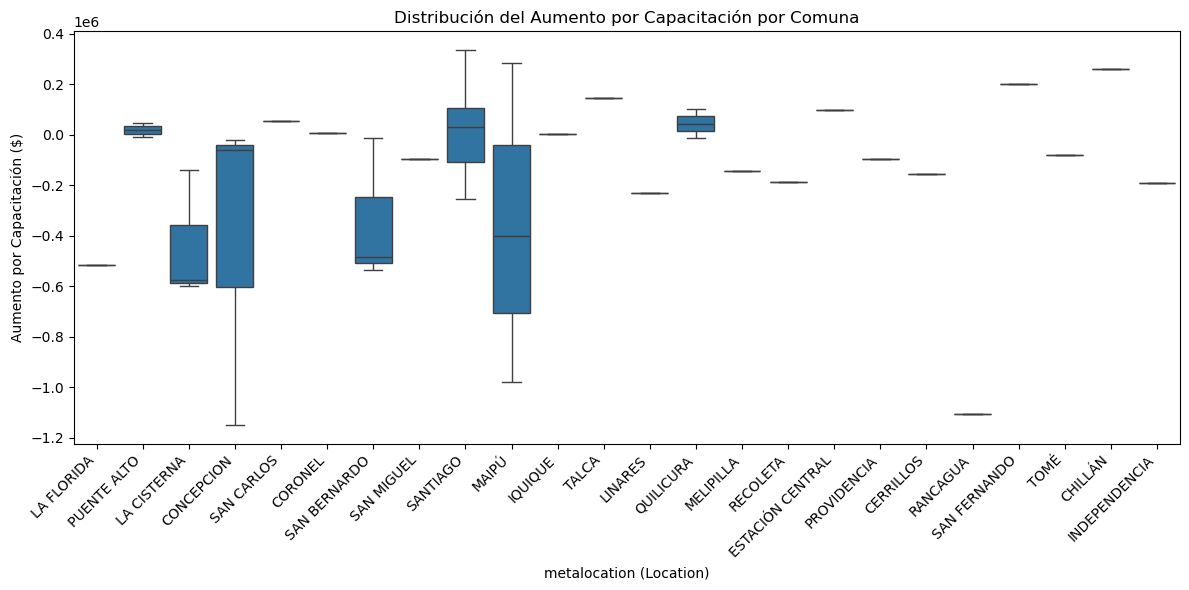

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_local, x='metalocation (Location)', y='aumento_por_capacitacion')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Aumento por Capacitación ($)")
plt.title("Distribución del Aumento por Capacitación por Comuna")
plt.tight_layout()
plt.show()


In [32]:
sellout = sellout.rename(columns={"código sap pos": "codigo_sap"})  # Asegurar nombre uniforme

sellout["codigo_sap"] = sellout["codigo_sap"].astype(str).str.strip()


# incluye sin capacitaciones
df_unido = pd.merge(
    sellout,
    cursos_por_local[['metashopcode (Door Code)', 'total_capacitaciones']],
    left_on='codigo_sap',
    right_on='metashopcode (Door Code)',
    how='left'
)


df_unido = df_unido[df_unido['ventas_2024'] != 0]
df_unido = df_unido[df_unido['ventas_2025'] != 0]

# Rellenar NaN con 0 para los que no tienen capacitación
df_unido['total_capacitaciones'] = df_unido['total_capacitaciones'].fillna(0)

# Calcular cambio de ventas en pesos
df_unido['cambio_pesos'] = df_unido['ventas_2025'] - df_unido['ventas_2024']


con_cap = df_unido[df_unido["total_capacitaciones"] > 0]
sin_cap = df_unido[df_unido["total_capacitaciones"] == 0]



# TABLA MÉTRICAS
resumen_valor = pd.DataFrame({
    "Grupo": ["Con capacitación", "Sin capacitación"],
    "Promedio cambio $": [con_cap["cambio_pesos"].mean(), sin_cap["cambio_pesos"].mean()],
    "Mediana cambio $": [con_cap["cambio_pesos"].median(), sin_cap["cambio_pesos"].median()],
    "Desviación estándar $": [con_cap["cambio_pesos"].std(), sin_cap["cambio_pesos"].std()],
    "Observaciones": [len(con_cap), len(sin_cap)]
})

print(resumen_valor.to_string(formatters={
    'Promedio cambio $': '{:,.2f}'.format,
    'Mediana cambio $': '{:,.2f}'.format,
    'Desviación estándar $': '{:,.2f}'.format
}))


              Grupo Promedio cambio $ Mediana cambio $ Desviación estándar $  Observaciones
0  Con capacitación       -274,055.06      -191,931.95          1,076,785.73             43
1  Sin capacitación       -474,090.97      -521,535.95          1,062,561.61            245


In [33]:
# MÉTRICAS PORCENTUALES

df_unido = df_unido[df_unido['ventas_2024'] != 0]  # Evitar división por cero (seguridad)
df_unido = df_unido[df_unido['ventas_2025'] != 0]
df_unido['cambio_pct'] = ((df_unido['ventas_2025'] - df_unido['ventas_2024']) / df_unido['ventas_2024']) * 100


con_cap = df_unido[df_unido["total_capacitaciones"] > 0]
sin_cap = df_unido[df_unido["total_capacitaciones"] == 0]

# TABLA MÉTRICAS PORCENTUALES
resumen_porcentual = pd.DataFrame({
    "Grupo": ["Con capacitación", "Sin capacitación"],
    "Promedio cambio %": [con_cap["cambio_pct"].mean(), sin_cap["cambio_pct"].mean()],
    "Mediana cambio %": [con_cap["cambio_pct"].median(), sin_cap["cambio_pct"].median()],
    "Desviación estándar %": [con_cap["cambio_pct"].std(), sin_cap["cambio_pct"].std()],
    "Observaciones": [len(con_cap), len(sin_cap)]
})

print(resumen_porcentual)


              Grupo  Promedio cambio %  Mediana cambio %  \
0  Con capacitación           7.189437         -5.337110   
1  Sin capacitación          -8.632459        -10.449297   

   Desviación estándar %  Observaciones  
0              67.699480             43  
1              71.311029            245  


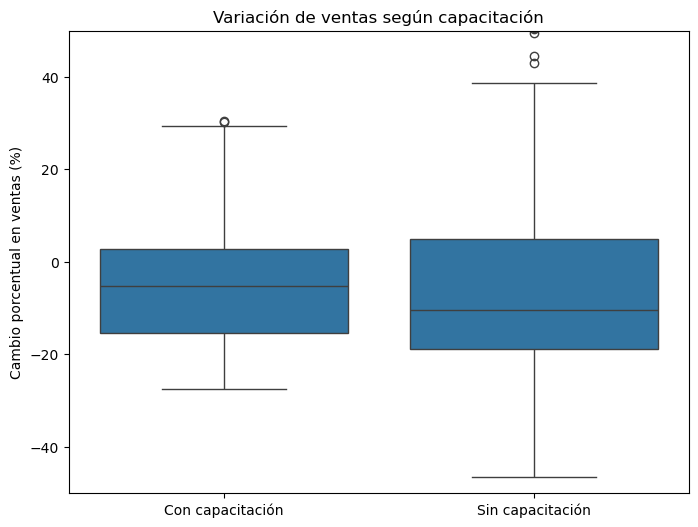

In [34]:
df_plot = pd.concat([
    con_cap.assign(Grupo='Con capacitación'),
    sin_cap.assign(Grupo='Sin capacitación')
])

plt.figure(figsize=(8, 6))
sns.boxplot(x='Grupo', y='cambio_pct', data=df_plot, showfliers=True)  # O showfliers=False si quieres ocultar outliers
plt.ylabel('Cambio porcentual en ventas (%)')
plt.xlabel('')
plt.title('Variación de ventas según capacitación')
plt.ylim(-50, 50)
plt.show()

In [35]:
promedio_con = con_cap["cambio_pesos"].mean()
promedio_sin = sin_cap["cambio_pesos"].mean()

diferencia_promedio = promedio_con - promedio_sin
print(f"Diferencia promedio: ${diferencia_promedio:,.2f}")


Diferencia promedio: $200,035.91
